In [1]:
import numpy as np 
import re 
import requests as req 
import matplotlib.pyplot as plt 
import pandas as pd 
from sodapy import Socrata
import geopy as gp
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import collections as col
from imblearn.over_sampling import SMOTENC, SMOTEN, SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [2]:
#FOUND API. no need for requests
# requ_url = 'https://www.dot.ny.gov/portal/pls/portal/MEXIS_APP.DYN_PROJECT_DETAILS.show'
# req_post = {'p_arg_names': 'p_pin', 'p_arg_values':801079}
# # resp = req.get(requ_url)
# def data_retrieval(url: str, key: list[str]) -> pd.DataFrame:
#     response = req.get(url)
#     if response.ok == True and response.status_code == 200:
#         print('Success')
#     else:
#         print('Failed')
#     data = response.json()
#     return data
# response = req.get(requ_url, params=req_post)
# print(response.text)

In [3]:
client = Socrata("data.ny.gov",app_token='SUV6CnpKWErb1fdYcxWDEXpHl', username='dwightdinkins@gmail.com',password='AVelaryon@2134')
results = client.get("rz8t-4kmq", limit=5000)
results_df = pd.DataFrame.from_records(results)
results_df.columns

Index(['major_pin', 'contract_number', 'region', 'project_title',
       'project_status', 'status', 'bid_opening_date', 'federal_funding',
       'state_funding', 'local_funding', 'type_of_work',
       'public_friendly_description', 'contract_award_date',
       'contract_award_amount', 'approved_cost_changes',
       'current_award_amount', 'estimated_or_actual_completed_date',
       'schedule_performance', 'cost_performance',
       'in_future_development_start_date', 'construction_start_date',
       'construction_end_date', 'construction_amount'],
      dtype='object')

# Data Pre-processing

In [4]:
group_status = results_df.groupby(by='status', as_index=False)
indx = (results_df.status.str.contains('Completed Project', regex=False).to_numpy() == 1).nonzero()

In [5]:
pd.set_option('display.max_columns', 23)
completed = results_df.iloc[indx[0],:].copy()
# Converted COntract Award Date & Estimated Completion Date to Datetime Objects
completed.contract_award_date = pd.to_datetime(completed.contract_award_date)
completed.estimated_or_actual_completed_date = pd.to_datetime(completed.estimated_or_actual_completed_date)

In [6]:
completed_dropped_contruct = completed.drop(columns=['construction_start_date', 'construction_end_date', 'construction_amount']).copy()

In [8]:
completed_dropped_contruct

,major_pin,contract_number,region,project_title,project_status,status,bid_opening_date,federal_funding,state_funding,local_funding,type_of_work,public_friendly_description,contract_award_date,contract_award_amount,approved_cost_changes,current_award_amount,estimated_or_actual_completed_date,schedule_performance,cost_performance,in_future_development_start_date
0,000616,D263845,10 LONG ISLAND,OP SHARED USE PATH TOBAY TO CAPTREE,Construction of 3rd phase of 14 mile shared-us...,Completed Project,04/17/2019,Yes,Yes,No,Bicycle Facility (Highway): New,Project proposes to construct the 3rd phase of...,2019-07-12,16193713,1387827.44,17581540.44,2020-11-25,GREEN,YELLOW,NaN
17,005927,D263713,10 LONG ISLAND,NY27 OAKDALE MERGE INTERCHANGE IMPVTS,NY27 Oakdale Merge Interchange Impvts - resurf...,Completed Project,06/07/2018,No,Yes,Yes,Pavement: Mill and Fill,"This project is located at the Oakdale Merge, ...",2018-08-16,7281160.4,357766.98,7638927.38,2020-09-14,RED,GREEN,Spring 2017
20,011260,D263735,10 LONG ISLAND,NY110 PEDESTRIAN SAFETY IMPROVEMENTS,Pedestrian safety improvements along NY110 be...,Completed Project,06/07/2018,Yes,Yes,No,Pedestrian Facility (Highway): Improve/Rehab,This project proposes to provide upgraded pede...,2018-07-23,3980019.75,459342.64,4439362.39,2020-09-18,RED,RED,Summer 2016
21,012112,D263907,10 LONG ISLAND,NY106 CONC PAVMT REPAIR NY24 TO OLD COUNTRY RD,CONCRETE PAVEMENT REPAIRS ON NY106 FROM NY24 T...,Completed Project,03/14/2019,Yes,Yes,No,"Pavement: Concrete Pavement Repair, Heavy",This project proposes to provide concrete pave...,2019-04-25,6820426.55,161953.24,6982379.79,2020-12-10,RED,GREEN,Winter 2016/2017
29,033915,D264032,10 LONG ISLAND,SMSP GUIDERAIL REHAB I495 TO END,REPAIR AND REPLACE GUIDERAIL SECTIONS SUNKEN M...,Completed Project,09/12/2019,Yes,Yes,No,Guiderail/Median Barrier: Rehab/Improve,This project proposes to replace existing the ...,2019-11-06,4464797.2,218.09,4465015.29,2021-06-18,GREEN,GREEN,Summer 2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1900,XM1850,D264063,11 NEW YORK CITY,"ADA REQUIREMENTS IN BRONX CO., NYC","Build curb ramps, crosswalks and sidewalks at ...",Completed Project,11/21/2019,Yes,Yes,No,Pedestrian Facility (Highway): Improve/Rehab,This project will build (either throught repla...,2020-01-08,874049.9,-282679.6,591370.3,2020-10-08,GREEN,GREEN,Fall 2018
1903,XM1860,D263918,11 NEW YORK CITY,CORRECTIVE & PREVENTIVE MAINTENANCE OF RETAINI...,CORRECTIVE AND REVENTIVE MAINTENANCE OF MASON...,Completed Project,03/28/2019,Yes,Yes,No,Retaining Wall: New/Improve/Rehab,"This project will repair and restore brick, st...",2019-06-25,14199865.45,-575172.71,13624692.74,2020-11-17,GREEN,GREEN,Summer 2015
1904,XM1921,D263839,11 NEW YORK CITY,"WHERE AND WHEN BRIDGE STEEL REPAIRS, ALL COUNT...",Perform emergency steel repairs to maintain st...,Completed Project,11/29/2018,No,Yes,No,Emergency Response Bridge Repair,This project will perform emergency steel repa...,2019-01-17,10555555,-690065.36,9865489.64,2021-01-19,GREEN,GREEN,Spring 2018
1905,XM1922,D263809,11 NEW YORK CITY,"CORRECTIVE MAINTENANCE REPAIR CONTRACT (NSCO),...","Address NSCO, flags & other conditions on brid...",Completed Project,12/13/2018,No,Yes,No,Emergency Response Bridge Repair,This project will perform maintenance repairs ...,2019-04-16,26680095,1113136.22,27793231.22,2020-10-19,RED,GREEN,Spring 2018


In [9]:

def modify_addy(regex: list[str], data: pd.DataFrame, dat_col: pd.Series):
    geolocator = Nominatim(user_agent='myGeocoder', timeout=10)
    geolocator = RateLimiter(geolocator.geocode, min_delay_seconds=1)
    hwy_data = dat_col.str.replace(regex[0],r'\1-\2', regex=True).str.extract(regex[1]).dropna()
    loc_data = col.defaultdict(dict)
    for indx, hwy in hwy_data.to_dict()[0].items():
        try:
            location = geolocator(hwy + ', NY', geometry='geojson')
            if location != None:
                loc_data['latitude'][indx] = location.latitude
                loc_data['longitude'][indx] = location.longitude
                # print(loc_data['longitude'][indx])
            else:
                loc_data['latitude'][indx] = np.nan
                loc_data['longitude'][indx] = np.nan
        except OSError:
            pass        

    return loc_data
    
    

In [ ]:
# regex = [r'([NYIRtT\.]+)\s?(\d+)',r'([NYIRtT\.]+-\d+)']
# location_data = modify_addy(regex, completed_dropped_contruct, completed_dropped_contruct.project_status)

In [ ]:
# location_data1 = modify_addy(regex, completed_dropped_contruct, completed_dropped_contruct.project_title)

In [10]:
location_data = pd.read_excel(r"C:\Users\dwigh\Downloads\location_data1.xlsx")
location_data1 = pd.read_excel(r"C:\Users\dwigh\Downloads\location_data.xlsx")

In [11]:
location_data

,Unnamed: 0,major_pin,contract_number,region,project_title,project_status,status,bid_opening_date,federal_funding,state_funding,local_funding,type_of_work,public_friendly_description,contract_award_date,contract_award_amount,approved_cost_changes,current_award_amount,estimated_or_actual_completed_date,schedule_performance,cost_performance,in_future_development_start_date,latitude,longitude
0,0,000616,D263845,10 LONG ISLAND,OP SHARED USE PATH TOBAY TO CAPTREE,Construction of 3rd phase of 14 mile shared-us...,Completed Project,04/17/2019,Yes,Yes,No,Bicycle Facility (Highway): New,Project proposes to construct the 3rd phase of...,2019-07-12,16193713.00,1387827.44,17581540.44,2020-11-25,GREEN,YELLOW,NaN,40.638981,-73.259978
1,17,005927,D263713,10 LONG ISLAND,NY27 OAKDALE MERGE INTERCHANGE IMPVTS,NY27 Oakdale Merge Interchange Impvts - resurf...,Completed Project,06/07/2018,No,Yes,Yes,Pavement: Mill and Fill,"This project is located at the Oakdale Merge, ...",2018-08-16,7281160.40,357766.98,7638927.38,2020-09-14,RED,GREEN,Spring 2017,40.657336,-73.899046
2,20,011260,D263735,10 LONG ISLAND,NY110 PEDESTRIAN SAFETY IMPROVEMENTS,Pedestrian safety improvements along NY110 be...,Completed Project,06/07/2018,Yes,Yes,No,Pedestrian Facility (Highway): Improve/Rehab,This project proposes to provide upgraded pede...,2018-07-23,3980019.75,459342.64,4439362.39,2020-09-18,RED,RED,Summer 2016,40.689344,-73.420269
3,21,012112,D263907,10 LONG ISLAND,NY106 CONC PAVMT REPAIR NY24 TO OLD COUNTRY RD,CONCRETE PAVEMENT REPAIRS ON NY106 FROM NY24 T...,Completed Project,03/14/2019,Yes,Yes,No,"Pavement: Concrete Pavement Repair, Heavy",This project proposes to provide concrete pave...,2019-04-25,6820426.55,161953.24,6982379.79,2020-12-10,RED,GREEN,Winter 2016/2017,40.691521,-73.542796
4,29,033915,D264032,10 LONG ISLAND,SMSP GUIDERAIL REHAB I495 TO END,REPAIR AND REPLACE GUIDERAIL SECTIONS SUNKEN M...,Completed Project,09/12/2019,Yes,Yes,No,Guiderail/Median Barrier: Rehab/Improve,This project proposes to replace existing the ...,2019-11-06,4464797.20,218.09,4465015.29,2021-06-18,GREEN,GREEN,Summer 2017,40.760208,-74.003219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,1900,XM1850,D264063,11 NEW YORK CITY,"ADA REQUIREMENTS IN BRONX CO., NYC","Build curb ramps, crosswalks and sidewalks at ...",Completed Project,11/21/2019,Yes,Yes,No,Pedestrian Facility (Highway): Improve/Rehab,This project will build (either throught repla...,2020-01-08,874049.90,-282679.60,591370.30,2020-10-08,GREEN,GREEN,Fall 2018,40.846651,-73.878594
287,1903,XM1860,D263918,11 NEW YORK CITY,CORRECTIVE & PREVENTIVE MAINTENANCE OF RETAINI...,CORRECTIVE AND REVENTIVE MAINTENANCE OF MASON...,Completed Project,03/28/2019,Yes,Yes,No,Retaining Wall: New/Improve/Rehab,"This project will repair and restore brick, st...",2019-06-25,14199865.45,-575172.71,13624692.74,2020-11-17,GREEN,GREEN,Summer 2015,40.712728,-74.006015
288,1904,XM1921,D263839,11 NEW YORK CITY,"WHERE AND WHEN BRIDGE STEEL REPAIRS, ALL COUNT...",Perform emergency steel repairs to maintain st...,Completed Project,11/29/2018,No,Yes,No,Emergency Response Bridge Repair,This project will perform emergency steel repa...,2019-01-17,10555555.00,-690065.36,9865489.64,2021-01-19,GREEN,GREEN,Spring 2018,40.712728,-74.006015
289,1905,XM1922,D263809,11 NEW YORK CITY,"CORRECTIVE MAINTENANCE REPAIR CONTRACT (NSCO),...","Address NSCO, flags & other conditions on brid...",Completed Project,12/13/2018,No,Yes,No,Emergency Response Bridge Repair,This project will perform maintenance repairs ...,2019-04-16,26680095.00,1113136.22,27793231.22,2020-10-19,RED,GREEN,Spring 2018,40.712728,-74.006015


In [12]:
location_data.set_index('Unnamed: 0', inplace=True)
location_data.index.name = ''

location_data1.set_index('Unnamed: 0', inplace=True)
location_data1.index.name = ''

In [13]:
location_data

,major_pin,contract_number,region,project_title,project_status,status,bid_opening_date,federal_funding,state_funding,local_funding,type_of_work,public_friendly_description,contract_award_date,contract_award_amount,approved_cost_changes,current_award_amount,estimated_or_actual_completed_date,schedule_performance,cost_performance,in_future_development_start_date,latitude,longitude
,,,,,,,,,,,,,,,,,,,,,,
0,000616,D263845,10 LONG ISLAND,OP SHARED USE PATH TOBAY TO CAPTREE,Construction of 3rd phase of 14 mile shared-us...,Completed Project,04/17/2019,Yes,Yes,No,Bicycle Facility (Highway): New,Project proposes to construct the 3rd phase of...,2019-07-12,16193713.00,1387827.44,17581540.44,2020-11-25,GREEN,YELLOW,NaN,40.638981,-73.259978
17,005927,D263713,10 LONG ISLAND,NY27 OAKDALE MERGE INTERCHANGE IMPVTS,NY27 Oakdale Merge Interchange Impvts - resurf...,Completed Project,06/07/2018,No,Yes,Yes,Pavement: Mill and Fill,"This project is located at the Oakdale Merge, ...",2018-08-16,7281160.40,357766.98,7638927.38,2020-09-14,RED,GREEN,Spring 2017,40.657336,-73.899046
20,011260,D263735,10 LONG ISLAND,NY110 PEDESTRIAN SAFETY IMPROVEMENTS,Pedestrian safety improvements along NY110 be...,Completed Project,06/07/2018,Yes,Yes,No,Pedestrian Facility (Highway): Improve/Rehab,This project proposes to provide upgraded pede...,2018-07-23,3980019.75,459342.64,4439362.39,2020-09-18,RED,RED,Summer 2016,40.689344,-73.420269
21,012112,D263907,10 LONG ISLAND,NY106 CONC PAVMT REPAIR NY24 TO OLD COUNTRY RD,CONCRETE PAVEMENT REPAIRS ON NY106 FROM NY24 T...,Completed Project,03/14/2019,Yes,Yes,No,"Pavement: Concrete Pavement Repair, Heavy",This project proposes to provide concrete pave...,2019-04-25,6820426.55,161953.24,6982379.79,2020-12-10,RED,GREEN,Winter 2016/2017,40.691521,-73.542796
29,033915,D264032,10 LONG ISLAND,SMSP GUIDERAIL REHAB I495 TO END,REPAIR AND REPLACE GUIDERAIL SECTIONS SUNKEN M...,Completed Project,09/12/2019,Yes,Yes,No,Guiderail/Median Barrier: Rehab/Improve,This project proposes to replace existing the ...,2019-11-06,4464797.20,218.09,4465015.29,2021-06-18,GREEN,GREEN,Summer 2017,40.760208,-74.003219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1900,XM1850,D264063,11 NEW YORK CITY,"ADA REQUIREMENTS IN BRONX CO., NYC","Build curb ramps, crosswalks and sidewalks at ...",Completed Project,11/21/2019,Yes,Yes,No,Pedestrian Facility (Highway): Improve/Rehab,This project will build (either throught repla...,2020-01-08,874049.90,-282679.60,591370.30,2020-10-08,GREEN,GREEN,Fall 2018,40.846651,-73.878594
1903,XM1860,D263918,11 NEW YORK CITY,CORRECTIVE & PREVENTIVE MAINTENANCE OF RETAINI...,CORRECTIVE AND REVENTIVE MAINTENANCE OF MASON...,Completed Project,03/28/2019,Yes,Yes,No,Retaining Wall: New/Improve/Rehab,"This project will repair and restore brick, st...",2019-06-25,14199865.45,-575172.71,13624692.74,2020-11-17,GREEN,GREEN,Summer 2015,40.712728,-74.006015
1904,XM1921,D263839,11 NEW YORK CITY,"WHERE AND WHEN BRIDGE STEEL REPAIRS, ALL COUNT...",Perform emergency steel repairs to maintain st...,Completed Project,11/29/2018,No,Yes,No,Emergency Response Bridge Repair,This project will perform emergency steel repa...,2019-01-17,10555555.00,-690065.36,9865489.64,2021-01-19,GREEN,GREEN,Spring 2018,40.712728,-74.006015


In [ ]:
location_data1[location_data1.longitude.isna()].shape

In [ ]:
pd.set_option('display.max_rows', 300)
regex = r'(\d+\s\w+\s[RAdVEveoOaD]+)'
regex1 = r'(\s[\w\s]+and\s[\w\s]+)'
regex2 = r'(?<=between\s)([\w\s]+)and([\w\s]+)'
regex3 = r'(?<=FROM\s)([\w\d\s]+)'
regex4 = r'([NYIRtT\.]+)\s?(\d+)'
regex5 = r'([NYIRtT\.]+-\d+)'
# completed_dropped_contruct.project_status.str.replace(regex4, r'\1-\2', regex=True).str.extract(regex5).dropna()
for i, descrip in location_data[location_data.longitude.isna()].project_status.to_dict().items():
    print(f'{i}: {descrip},')


In [ ]:
location_data[location_data.longitude.isna()]

In [14]:
location_data.loc[1540, ['latitude', 'longitude']] = [42.252865, -73.790962]

In [15]:
rem ={
    0: "Captree State Park",
    32: "Hempstead",
    33: "Commack Rd, Huntington",
    41: "Nassau",
    42: "SUFFOLK",
    43: "NY-25A",
    44: "Nassau",
    46: "SUFFOLK",
    48: "NY-347",
    49: "NY-231",
    51: "Riverhead",
    59: "Nassau",
    62: "Montauk Hwy",
    63: "Old Sunrise Highway",
    64: "William Floyd Pkwy",
    68: "NY-27",
    93: "NY-24",
    254: "New York State",
    279: "ROUTE 29",
    327: "NEW YORK CITY",
    329: "Mohawk Hudson Bike Trail",
    403: "EMPIRE STATE TRAIL",
    442: "NY-418",
    485: "ONEIDA",
    487: "EAST HERKIMER",
    488: "TRENTON & REMSEN",
    490: "HERKIMER",
    491: "NEW HARTFORD",
    497: "New York State",
    503: "New York State",
    580: "Geddes",
    581: "Bronx",
    621: "New York City",
    638: "Manlius",
    644: "ONONDAGA",
    648: "SENECA COUNTY",
    649: "CORTLAND COUNTY",
    652: "TOMPKINS COUNTY",
    668: "TOMPKINS COUNTY",
    671: "I-690",
    672: "CAYUGA",
    676: "OSWEGO",
    759: "MONROE COUNTY",
    769: "Orleans County",
    774: "Empire State Trail",
    775: "MACEDON",
    803: "Edgemere Dr.",
    862: "Livingston County",
    900: "New York State",
    913: "ROUTE 179",
    931: "Amherst",
    934: "Erie County",
    936: "Cattaraugus County",
    939: "Niagara County",
    940: "ERIE COUNTY",
    943: "Niagara County",
    944: "Lewiston",
    949: "Chautauqua",
    951: "Erie County",
    963: "US-62",
    1040: "CATTARAUGUS COUNTY",
    1041: "ERIE COUNTY",
    1042: "NY-426",
    1103: "Empire State Trail",
    1112: "US-20",
    1114: "US-62",
    1120: "US-20",
    1126: "US-20A",
    1128: "NIAGARA FALLS BLVD",
    1130: "New York State",
    1173: "Chemung",
    1177: "SCHUYLER",
    1178: "STEUBEN",
    1179: "I-86",
    1181: "STEUBEN & YATES",
    1229: "YATES",
    1234: "Schuyler & Steuben",
    1289: "New York State",
    1291: "New York State",
    1292: "New York State",
    1293: "New York State",
    1294: "Central New York",
    1296: "Central New York",
    1297: "New York State",
    1332: "New York State",
    1344: "ROUTE 116",
    1346: "ROUTE 100",
    1351: "ROUTE 203",
    1373: "ROUTE 22",
    1383: "ANNSVILLE CIRCLE",
    1387: "ROUTE 202",
    1388: "OAKLEY BOULEVARD",
    1399: "New York State",
    1402: "ROCKLAND & WESTCHESTER COUNTY",
    1403: "New York State",
    1405: "ROCKLAND COUNTY",
    1406: "Putnam & Ulster",
    1409: "ROUTE 213",
    1413: "ORANGE & WESTCHESTER",
    1415: "Dutchess County",
    1416: "PUTNAM County",
    1440: "New York State",
    1450: "Westchester",
    1455: "New York State",
    1462: "New York State",
    1469: "New York State",
    1476: "New York State",
    1484: "Orange & Putnam",
    1487: "Rockland",
    1489: "Ulster",
    1520: "SAW MILL RIVER PARKWAY",
    1522: "PUTNAM & WESTCHESTER",
    1528: "GREENBURGH",
    1529: "HAVERSTRAW",
    1536: "Route 44",
    1538: "ROUTE 17K",
    1539: "HUNGRY HOLLOW ROAD",
    1540: "NEW PALTZ & LLYOD",
    1635: "ROUTE 59",
    1637: "TACONIC PARKWAY",
    1639: "EMPIRE STATE TRAIL, KINGSTON",
    1640: "ALBANY HUDSON ELECTRIC TRAIL",
    1654: "Bethel",
    1673: "Owego",
    1717: "Chenango",
    1719: "US-11",
    1761: "Wyoming",
    1787: "Route 97",
    1866: "I-278",
    1882: "Van Wyck Expressway",
    1887: "New York City",
    1894: "New York State",
    1895: "New York City",
    1896: "New York City",
    1897: "New York City",
    1898: "New York city",
    1900: "Bronx",
    1903: "New York City",
    1904: "NYC",
    1905: "NYC",
    1908: "West 57th St."
}


In [ ]:
geolocator = Nominatim(user_agent='myGeocoder', timeout=10)
location = geolocator.geocode('West 57th St., NY', geometry='geojson', exactly_one=True)
location.latitude, location.longitude

In [ ]:
geolocator = Nominatim(user_agent='myGeocoder', timeout=10)
geolocator = RateLimiter(geolocator.geocode, min_delay_seconds=1)
loc_data = col.defaultdict(dict)
for indx, hwy in rem.items():
    try:
        location = geolocator(hwy + ', NY', geometry='geojson')
        if location != None:
            loc_data['latitude'][indx] = location.latitude
            loc_data['longitude'][indx] = location.longitude
            # print(loc_data['longitude'][indx])
        else:
            loc_data['latitude'][indx] = np.nan
            loc_data['longitude'][indx] = np.nan
    except OSError:
        pass

In [ ]:
# location_data[['latitude', 'longitude']] = location_data[['latitude', 'longitude']].combine_first(pd.DataFrame(loc_data))

In [ ]:
# (location_data[['latitude', 'longitude']].isna() == True).to_numpy().nonzero()

In [16]:
tow = location_data.type_of_work.str.replace('/',' ').str.replace(':', '').str.replace('(','').str.replace(')','').str.replace(',','')
tow


0                    Bicycle Facility Highway New
17                         Pavement Mill and Fill
20      Pedestrian Facility Highway Improve Rehab
21        Pavement Concrete Pavement Repair Heavy
29         Guiderail Median Barrier Rehab Improve
                          ...                    
1900    Pedestrian Facility Highway Improve Rehab
1903             Retaining Wall New Improve Rehab
1904             Emergency Response Bridge Repair
1905             Emergency Response Bridge Repair
1908      Pavement Concrete Pavement Repair Heavy
Name: type_of_work, Length: 291, dtype: object

In [17]:
words = tow.str.split().to_numpy()
unique_set = list()
for word in words:
  print(word)
  unique_set.extend(word)
num_of_appearance = dict()
for item in set(unique_set):
  num_of_appearance[item] = unique_set.count(item)

['Bicycle', 'Facility', 'Highway', 'New']
['Pavement', 'Mill', 'and', 'Fill']
['Pedestrian', 'Facility', 'Highway', 'Improve', 'Rehab']
['Pavement', 'Concrete', 'Pavement', 'Repair', 'Heavy']
['Guiderail', 'Median', 'Barrier', 'Rehab', 'Improve']
['Pavement', 'Mill', 'and', 'Fill']
['Guiderail', 'Median', 'Barrier', 'Rehab', 'Improve']
['Bridge', 'Replacement', 'Functional']
['Traffic', 'Signals', 'Devices', 'Coordination']
['Bridge', 'Maintenance', 'Cyclical', 'Washing', 'Sealing', 'Cleaning', 'etc.']
['Pavement', 'Mill', 'and', 'Fill']
['Other']
['Emergency', 'Response', 'Highway']
['Pavement', 'Mill', 'and', 'Fill']
['Pavement', 'Mill', 'and', 'Fill']
['Bridge', 'Deck', 'Replacement']
['Pavement', 'Marking']
['Pavement', 'Crack', 'or', 'Joint', 'Sealing']
['Pavement', 'Concrete', 'Pavement', 'Repair', 'Heavy']
['Pavement', 'Mill', 'and', 'Fill']
['Pavement', 'Mill', 'and', 'Fill']
['Pedestrian', 'Facility', 'Highway', 'New']
['Bridge', 'Vertical', 'Down', 'Rehab']
['Pavement', 'Sing

In [18]:
num_of_appearance

{'Metering': 1,
 'Highway': 29,
 'Asphalt': 5,
 'Services': 1,
 'Cyclical': 11,
 'Ramp': 1,
 'Deck': 12,
 'Signals': 11,
 'Reconstruction': 5,
 'Coordination': 11,
 'Work': 2,
 'Painting': 9,
 'Pavement': 134,
 'Culvert': 13,
 'Fill': 43,
 'Non-Bridge': 2,
 'Joint': 5,
 'New': 20,
 'Path': 3,
 'Partial': 1,
 'Down': 3,
 'Cleaning': 11,
 'PM': 4,
 'Mill': 43,
 'MUL': 1,
 'Storage': 1,
 'Wall': 1,
 'Transit': 1,
 'or': 6,
 'Signal': 1,
 'Repair': 22,
 'Improve': 21,
 'Course': 39,
 'Hot-in-Place': 3,
 'Treatment': 4,
 'Washing': 11,
 'Capital': 2,
 'Two': 1,
 'Barrier': 10,
 'Landscape': 4,
 'Preservation': 8,
 'Heavy': 6,
 'Bicycle': 7,
 'Pedestrian': 16,
 'Alignment': 2,
 'Marking': 10,
 'Other': 6,
 'Facility': 23,
 'T&L': 1,
 'Guiderail': 10,
 'Traffic': 15,
 'Retaining': 1,
 'Cold-in-Place': 11,
 'Bridge': 77,
 'Use': 3,
 'Functional': 1,
 'Devices': 11,
 'Maintenance': 22,
 'etc.': 22,
 'Crack': 5,
 'Replacement': 30,
 'ICM': 1,
 'Single': 34,
 'and': 43,
 'Concrete': 6,
 'with': 1

In [19]:
pattern = re.compile(r'(Bridge|Pavement|Highway|Traffic|Guiderail|Culvert|Drainage|Vegetation)')
categories = tow.str.extract(pattern)
categories

,0
,
0,Highway
17,Pavement
20,Highway
21,Pavement
29,Guiderail
...,...
1900,Highway
1903,NaN
1904,Bridge


In [20]:
location_data.type_of_work[categories[0].isna()] = 'Other'
location_data.type_of_work[categories[0].notna()] = categories[0]

C:\Users\dwigh\AppData\Local\Temp\ipykernel_25304\634246089.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data.type_of_work[categories[0].isna()] = 'Other'
C:\Users\dwigh\AppData\Local\Temp\ipykernel_25304\634246089.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data.type_of_work[categories[0].notna()] = categories[0]


In [21]:
# pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 23)
location_data.head(5)

,major_pin,contract_number,region,project_title,project_status,status,bid_opening_date,federal_funding,state_funding,local_funding,type_of_work,public_friendly_description,contract_award_date,contract_award_amount,approved_cost_changes,current_award_amount,estimated_or_actual_completed_date,schedule_performance,cost_performance,in_future_development_start_date,latitude,longitude
,,,,,,,,,,,,,,,,,,,,,,
0,000616,D263845,10 LONG ISLAND,OP SHARED USE PATH TOBAY TO CAPTREE,Construction of 3rd phase of 14 mile shared-us...,Completed Project,04/17/2019,Yes,Yes,No,Highway,Project proposes to construct the 3rd phase of...,2019-07-12,16193713.00,1387827.44,17581540.44,2020-11-25,GREEN,YELLOW,NaN,40.638981,-73.259978
17,005927,D263713,10 LONG ISLAND,NY27 OAKDALE MERGE INTERCHANGE IMPVTS,NY27 Oakdale Merge Interchange Impvts - resurf...,Completed Project,06/07/2018,No,Yes,Yes,Pavement,"This project is located at the Oakdale Merge, ...",2018-08-16,7281160.40,357766.98,7638927.38,2020-09-14,RED,GREEN,Spring 2017,40.657336,-73.899046
20,011260,D263735,10 LONG ISLAND,NY110 PEDESTRIAN SAFETY IMPROVEMENTS,Pedestrian safety improvements along NY110 be...,Completed Project,06/07/2018,Yes,Yes,No,Highway,This project proposes to provide upgraded pede...,2018-07-23,3980019.75,459342.64,4439362.39,2020-09-18,RED,RED,Summer 2016,40.689344,-73.420269
21,012112,D263907,10 LONG ISLAND,NY106 CONC PAVMT REPAIR NY24 TO OLD COUNTRY RD,CONCRETE PAVEMENT REPAIRS ON NY106 FROM NY24 T...,Completed Project,03/14/2019,Yes,Yes,No,Pavement,This project proposes to provide concrete pave...,2019-04-25,6820426.55,161953.24,6982379.79,2020-12-10,RED,GREEN,Winter 2016/2017,40.691521,-73.542796
29,033915,D264032,10 LONG ISLAND,SMSP GUIDERAIL REHAB I495 TO END,REPAIR AND REPLACE GUIDERAIL SECTIONS SUNKEN M...,Completed Project,09/12/2019,Yes,Yes,No,Guiderail,This project proposes to replace existing the ...,2019-11-06,4464797.20,218.09,4465015.29,2021-06-18,GREEN,GREEN,Summer 2017,40.760208,-74.003219


In [20]:
x_columns = ['major_pin', 'contract_number', 'region', 'status', 'bid_opening_date', 'federal_funding',
       'state_funding', 'local_funding', 'type_of_work',
        'contract_award_date',
       'contract_award_amount', 'approved_cost_changes',
       'current_award_amount',
       'schedule_performance', 'cost_performance',
        'latitude', 'longitude']
y_column = 'current_award_amount'

In [22]:
dropped_contract_numbers = location_data.drop(index = (location_data[location_data.contract_number.isna()]).index)

In [23]:
dropped_contract_numbers = dropped_contract_numbers.drop(columns=['public_friendly_description', 'project_title', 'project_status', 'major_pin', 'contract_number', 'bid_opening_date',
                                                                 'current_award_amount', 'schedule_performance', 'cost_performance',
                                                                'in_future_development_start_date'])

In [24]:
dropped_contract_numbers

,region,status,federal_funding,state_funding,local_funding,type_of_work,contract_award_date,contract_award_amount,approved_cost_changes,estimated_or_actual_completed_date,latitude,longitude
,,,,,,,,,,,,
0,10 LONG ISLAND,Completed Project,Yes,Yes,No,Highway,2019-07-12,16193713.00,1387827.44,2020-11-25,40.638981,-73.259978
17,10 LONG ISLAND,Completed Project,No,Yes,Yes,Pavement,2018-08-16,7281160.40,357766.98,2020-09-14,40.657336,-73.899046
20,10 LONG ISLAND,Completed Project,Yes,Yes,No,Highway,2018-07-23,3980019.75,459342.64,2020-09-18,40.689344,-73.420269
21,10 LONG ISLAND,Completed Project,Yes,Yes,No,Pavement,2019-04-25,6820426.55,161953.24,2020-12-10,40.691521,-73.542796
29,10 LONG ISLAND,Completed Project,Yes,Yes,No,Guiderail,2019-11-06,4464797.20,218.09,2021-06-18,40.760208,-74.003219
...,...,...,...,...,...,...,...,...,...,...,...,...
1900,11 NEW YORK CITY,Completed Project,Yes,Yes,No,Highway,2020-01-08,874049.90,-282679.60,2020-10-08,40.846651,-73.878594
1903,11 NEW YORK CITY,Completed Project,Yes,Yes,No,Other,2019-06-25,14199865.45,-575172.71,2020-11-17,40.712728,-74.006015
1904,11 NEW YORK CITY,Completed Project,No,Yes,No,Bridge,2019-01-17,10555555.00,-690065.36,2021-01-19,40.712728,-74.006015


In [20]:
new_x_columns = dropped_contract_numbers.columns

In [25]:
dropped_contract_numbers.federal_funding = dropped_contract_numbers.federal_funding.astype('category')
dropped_contract_numbers.state_funding = dropped_contract_numbers.state_funding.astype('category')
dropped_contract_numbers.local_funding = dropped_contract_numbers.local_funding.astype('category')
dropped_contract_numbers.region = dropped_contract_numbers.region.astype('category')

In [26]:
dropped_contract_numbers['type_of_work'] = dropped_contract_numbers['type_of_work'].str.replace('Vegetation', 'Other')
dropped_contract_numbers['type_of_work'] = dropped_contract_numbers['type_of_work'].str.replace('Culvert','Drainage')
dropped_contract_numbers['type_of_work'] = dropped_contract_numbers['type_of_work'].str.replace('Guiderail','Traffic')
dropped_contract_numbers['type_of_work'] = dropped_contract_numbers['type_of_work'].str.replace('Pavement','Highway')
dropped_contract_numbers['type_of_work'] = dropped_contract_numbers['type_of_work'].str.replace('Bridge','Highway')


In [26]:
dropped_contract_numbers.describe()

,contract_award_date,contract_award_amount,approved_cost_changes,estimated_or_actual_completed_date,latitude,longitude
count,232,2.320000e+02,2.320000e+02,232,232.000000,232.000000
mean,2019-10-29 08:35:10.344827648,5.620255e+06,2.164592e+05,2020-12-23 12:12:24.827586304,41.643586,-73.284525
min,2016-04-18 00:00:00,1.090910e+05,-1.825961e+06,2019-07-01 00:00:00,13.524834,-79.739882
25%,2019-06-09 06:00:00,1.428950e+06,-1.112334e+05,2020-10-21 18:00:00,41.025307,-76.896141
50%,2019-12-23 12:00:00,2.565141e+06,0.000000e+00,2020-11-24 00:00:00,42.200471,-74.044566
75%,2020-04-07 06:00:00,4.801086e+06,1.157381e+05,2021-01-21 06:00:00,43.001888,-73.730197
max,2021-05-06 00:00:00,2.041700e+08,3.040055e+07,2021-10-01 00:00:00,50.285611,19.046648
std,NaN,1.520082e+07,2.092601e+06,NaN,3.944912,13.054169


<Figure size 1920x1440 with 0 Axes>

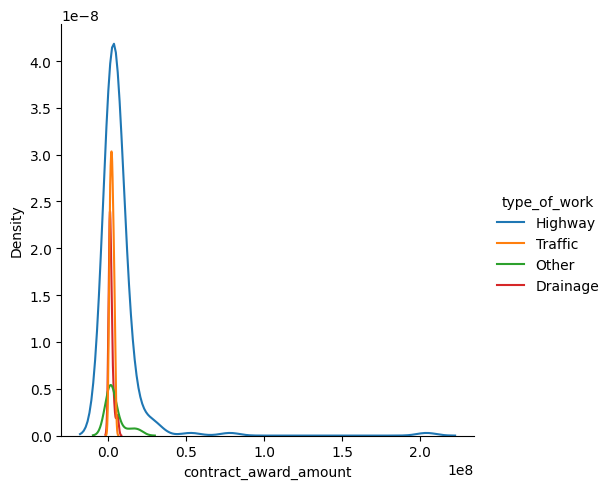

In [27]:
import seaborn as sns
plt.figure(dpi=300)
sns.displot(dropped_contract_numbers, x='contract_award_amount', hue='type_of_work', kind='kde')

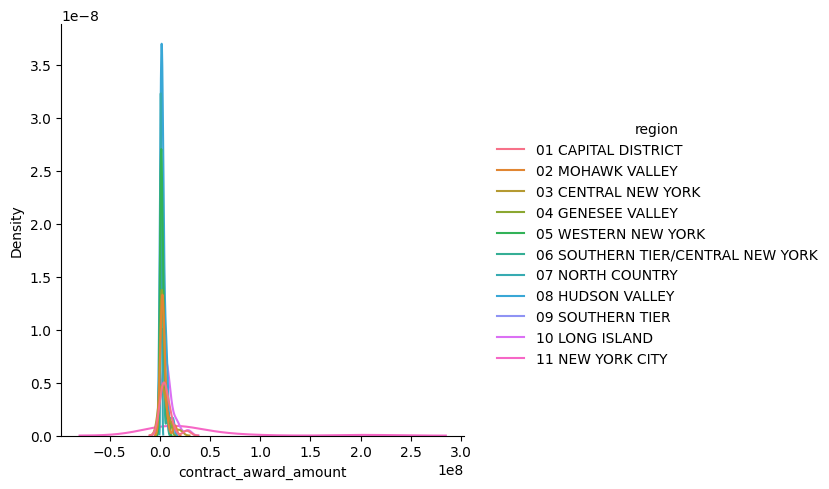

In [28]:
sns.displot(dropped_contract_numbers, x='contract_award_amount', hue='region', kind='kde')

In [27]:
location_data.contract_award_amount = location_data.contract_award_amount.apply(lambda x: x/100_000)

In [92]:
cleaned_data = dropped_contract_numbers.drop(columns=['status','contract_award_amount', 'approved_cost_changes','estimated_or_actual_completed_date'])

In [31]:
categories = [
	cleaned_data['region'].unique().tolist(),
	cleaned_data['federal_funding'].unique().tolist(),
	cleaned_data['state_funding'].unique().tolist(),
	cleaned_data['local_funding'].unique().tolist(),
	cleaned_data['type_of_work'].unique().tolist()
]

ordinal = OrdinalEncoder(categories=categories)
ordinal.fit(cleaned_data[['region', 'federal_funding', 'state_funding', 'local_funding', 'type_of_work']])

OrdinalEncoder(categories=[['10 LONG ISLAND', '01 CAPITAL DISTRICT',
                            '11 NEW YORK CITY', '02 MOHAWK VALLEY',
                            '03 CENTRAL NEW YORK', '04 GENESEE VALLEY',
                            '05 WESTERN NEW YORK',
                            '06 SOUTHERN TIER/CENTRAL NEW YORK',
                            '07 NORTH COUNTRY', '08 HUDSON VALLEY',
                            '09 SOUTHERN TIER'],
                           ['Yes', 'No'], ['Yes', 'No'], ['No', 'Yes'],
                           ['Highway', 'Traffic', 'Other', 'Drainage']])

In [93]:
categories = [
	cleaned_data['region'].unique().tolist(),
	cleaned_data['federal_funding'].unique().tolist(),
	cleaned_data['state_funding'].unique().tolist(),
	cleaned_data['local_funding'].unique().tolist(),
	cleaned_data['type_of_work'].unique().tolist()
]
one_hot_columns = ['region', 'federal_funding', 'state_funding', 'local_funding', 'type_of_work']
one_hot = OneHotEncoder(categories=categories, sparse_output=False)
one_hot.fit(cleaned_data[one_hot_columns])

OneHotEncoder(categories=[['10 LONG ISLAND', '01 CAPITAL DISTRICT',
                           '11 NEW YORK CITY', '02 MOHAWK VALLEY',
                           '03 CENTRAL NEW YORK', '04 GENESEE VALLEY',
                           '05 WESTERN NEW YORK',
                           '06 SOUTHERN TIER/CENTRAL NEW YORK',
                           '07 NORTH COUNTRY', '08 HUDSON VALLEY',
                           '09 SOUTHERN TIER'],
                          ['Yes', 'No'], ['Yes', 'No'], ['No', 'Yes'],
                          ['Highway', 'Traffic', 'Other', 'Drainage']],
              sparse_output=False)

In [94]:
one_hot.transform(cleaned_data[one_hot_columns])

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [95]:
one_hot_transformed_data = pd.DataFrame(np.hstack((one_hot.transform(cleaned_data[one_hot_columns]), cleaned_data[['latitude','longitude']])), columns = list(one_hot.get_feature_names_out()) + ['latitude', 'longitude'])

In [96]:
one_hot_transformed_data.columns

Index(['region_10 LONG ISLAND', 'region_01 CAPITAL DISTRICT',
       'region_11 NEW YORK CITY', 'region_02 MOHAWK VALLEY',
       'region_03 CENTRAL NEW YORK', 'region_04 GENESEE VALLEY',
       'region_05 WESTERN NEW YORK',
       'region_06 SOUTHERN TIER/CENTRAL NEW YORK', 'region_07 NORTH COUNTRY',
       'region_08 HUDSON VALLEY', 'region_09 SOUTHERN TIER',
       'federal_funding_Yes', 'federal_funding_No', 'state_funding_Yes',
       'state_funding_No', 'local_funding_No', 'local_funding_Yes',
       'type_of_work_Highway', 'type_of_work_Traffic', 'type_of_work_Other',
       'type_of_work_Drainage', 'latitude', 'longitude'],
      dtype='object')

In [86]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 232 entries, 0 to 1908
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   region               232 non-null    category      
 1   federal_funding      232 non-null    category      
 2   state_funding        232 non-null    category      
 3   local_funding        232 non-null    category      
 4   type_of_work         232 non-null    object        
 5   contract_award_date  232 non-null    datetime64[ns]
 6   latitude             232 non-null    float64       
 7   longitude            232 non-null    float64       
dtypes: category(4), datetime64[ns](1), float64(2), object(1)
memory usage: 18.8+ KB


In [33]:
cleaned_data.sort_values(by='contract_award_date', inplace=True)

In [98]:
current_award_amount = location_data.loc[cleaned_data.index, 'current_award_amount'].apply(lambda x: (x-location_data.current_award_amount.min())/(location_data.current_award_amount.max() - location_data.current_award_amount.min()))

In [ ]:
# current_award_amount.drop(index=current_award_amount[current_award_amount > 3].index, inplace=True)

<Axes: ylabel='Density'>

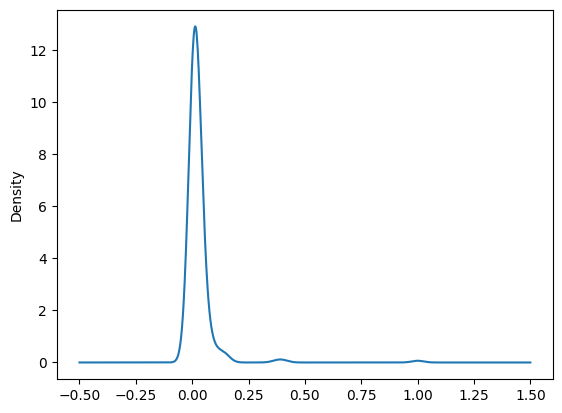

In [99]:
current_award_amount.plot(kind='kde')

In [100]:
norm_caa = current_award_amount.copy()

In [101]:
location_data.region[cleaned_data.index]


0         10 LONG ISLAND
17        10 LONG ISLAND
20        10 LONG ISLAND
21        10 LONG ISLAND
29        10 LONG ISLAND
              ...       
1900    11 NEW YORK CITY
1903    11 NEW YORK CITY
1904    11 NEW YORK CITY
1905    11 NEW YORK CITY
1908    11 NEW YORK CITY
Name: region, Length: 232, dtype: object

In [37]:
# from sklearn.preprocessing import KBinsDiscretizer
# nun = len(cleaned_data.region.unique())
# discret = KBinsDiscretizer(n_bins=nun, encode='ordinal', random_state=0)
# Y_binned = discret.fit_transform(norm_caa.to_numpy().reshape(-1,1)).ravel()
# smote = SMOTENC(categorical_features=['region'],sampling_strategy='auto', random_state=0)
# X_res , y_res = smote.fit_resample(ordinal.transform(cleaned_data[['region', 'federal_funding', 'state_funding', 'local_funding', 'type_of_work']]), Y_binned)



In [103]:
norm_caa.max()

np.float64(1.0)

In [104]:
cleaned_data = cleaned_data.loc[norm_caa.index]

In [84]:
# FOr Ordinal Output

# columns_to_transform = ['region', 'federal_funding', 'state_funding', 'local_funding', 'type_of_work']
# transformed_data = pd.DataFrame(np.hstack((ordinal.transform(cleaned_data[columns_to_transform]), cleaned_data[['latitude', 'longitude']].to_numpy())), columns=columns_to_transform + ['latitude', 'longitude'], index=cleaned_data.index)

# X_train, X_test, y_train, y_test = train_test_split(transformed_data,norm_caa, test_size=0.2, random_state=0)

In [105]:
one_hot_transformed_data.index = norm_caa.index
X_train, X_test, y_train, y_test = train_test_split(one_hot_transformed_data,norm_caa, test_size=0.2, random_state=0)

In [107]:
y_train


710     0.013444
310     0.047637
1146    0.012105
638     0.001873
1710    0.019113
          ...   
652     0.012372
1640    0.019355
1103    0.010524
480     0.046124
1450    0.014755
Name: current_award_amount, Length: 185, dtype: float64

In [108]:
RF = RandomForestRegressor(random_state=0)
# RF.fit(X_train, y_train)
# print(f'Training Score: {np.square(y_train - RF.predict(X_train)).mean()}')
# print(f'Testing Score: {np.square(y_test - RF.predict(X_test)).mean()}')   

In [109]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

param_space = dict()
param_space['n_estimators'] = Integer(10, 200)
param_space['max_samples'] = Integer(10, 100)
param_space['max_features'] = Categorical(['sqrt', 'log2'])
param_space['min_samples_split'] = Integer(2, 9)
# param_space['criterion'] = Categorical(['squared_error', 'absolute_error', 'friedman_mse'])
bae = BayesSearchCV(RF, param_space, n_iter=300,n_points=6, cv=4, n_jobs=24, random_state=0)
bae.fit(X_train, y_train)
print(bae.best_params_)
bae = pd.DataFrame(bae.cv_results_)
bae.to_csv(r"C:\Users\dwigh\Downloads\GIS_bae_OneHot.csv")

c:\Users\dwigh\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('sqrt'), np.int64(13), np.int64(2), np.int64(157)] before, using random point ['sqrt', np.int64(67), np.int64(7), np.int64(134)]
  warnings.warn(
c:\Users\dwigh\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('sqrt'), np.int64(13), np.int64(2), np.int64(157)] before, using random point ['log2', np.int64(79), np.int64(7), np.int64(150)]
  warnings.warn(
c:\Users\dwigh\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('sqrt'), np.int64(13), np.int64(2), np.int64(157)] before, using random point ['sqrt', np.int64(11), np.int64(5), np.int64(113)]
  warnings.warn(
c:\Users\dwigh\AppData\Local\Programs\Python\Pyth

OrderedDict({'max_features': 'log2', 'max_samples': 13, 'min_samples_split': 8, 'n_estimators': 40})


In [110]:
RF = RandomForestRegressor(n_estimators=40, max_samples=13, max_features='log2',min_samples_split=8, random_state=0)
RF.fit(X_train, y_train)
print(f'Training Score: {np.square(y_train - RF.predict(X_train)).mean()}')
print(f'Testing Score: {np.square(y_test - RF.predict(X_test)).mean()}')   

Training Score: 0.005503931888847895
Testing Score: 0.0022319352835141817


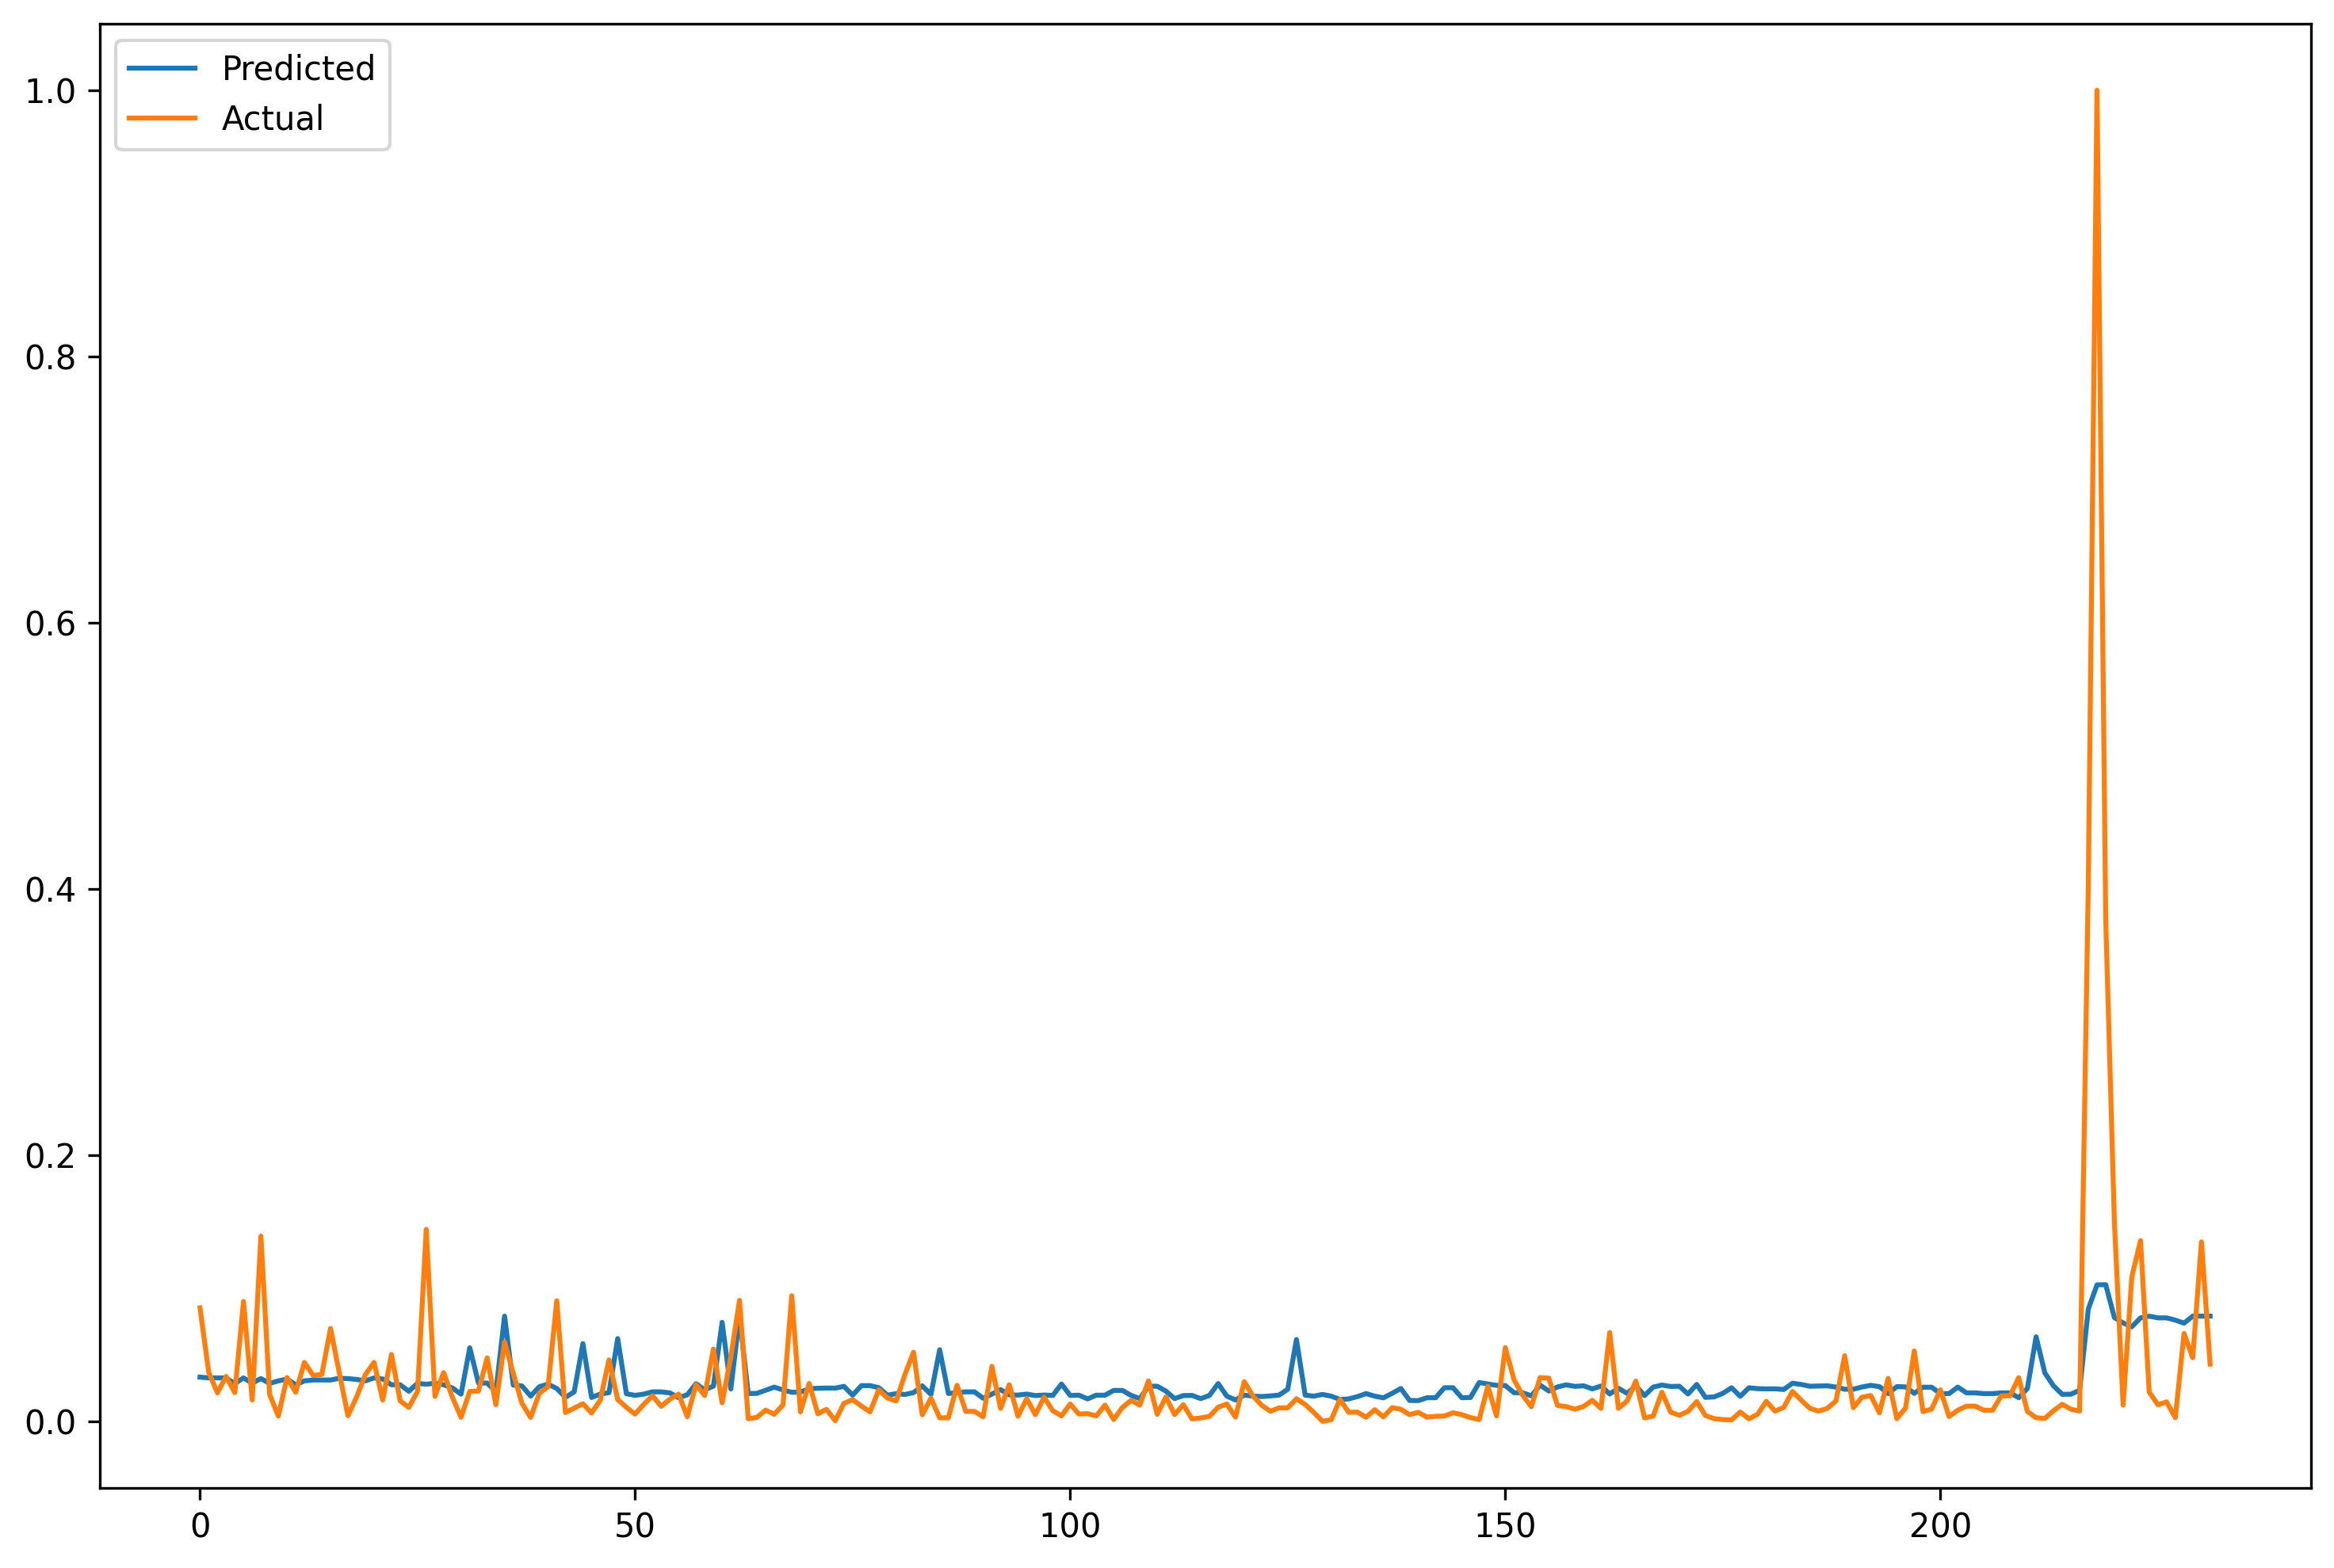

In [111]:
fig, ax = plt.subplots(1,1, figsize=(12,8), dpi=300)
ax.plot(range(one_hot_transformed_data.shape[0]), RF.predict(one_hot_transformed_data), label='Predicted')
ax.plot(range(one_hot_transformed_data.shape[0]), norm_caa, label='Actual')
ax.legend()
plt.show()

In [112]:
def pvit(data: pd.DataFrame,y_true: pd.Series, f: callable):
    rows, columns = data.shape
    Vy = np.var(y_true)
    ST = dict()
    for col in data.columns:
        d = data.copy()
        perm_feat = np.roll(data[col].to_numpy(), rows//2, axis=0)
        d[col] = perm_feat
        y_pred = f(d)
        ST[col] = np.square(y_true - y_pred).mean()/(2*Vy)
    return ST

In [114]:
pvit(X_train, y_train, RF.predict)
sum(pvit(X_test, y_test, RF.predict).values())

np.float64(7.978328797040778)

In [115]:
pvit(X_train, y_train, RF.predict)

{'region_10 LONG ISLAND': np.float64(0.41851871053865736),
 'region_01 CAPITAL DISTRICT': np.float64(0.41814178143520664),
 'region_11 NEW YORK CITY': np.float64(0.4886159822196191),
 'region_02 MOHAWK VALLEY': np.float64(0.4187068361182768),
 'region_03 CENTRAL NEW YORK': np.float64(0.41830803180949083),
 'region_04 GENESEE VALLEY': np.float64(0.4182136339142692),
 'region_05 WESTERN NEW YORK': np.float64(0.4182443824340798),
 'region_06 SOUTHERN TIER/CENTRAL NEW YORK': np.float64(0.41824917256545124),
 'region_07 NORTH COUNTRY': np.float64(0.4187517824287158),
 'region_08 HUDSON VALLEY': np.float64(0.4184066407147378),
 'region_09 SOUTHERN TIER': np.float64(0.41831678431825714),
 'federal_funding_Yes': np.float64(0.4186611389517864),
 'federal_funding_No': np.float64(0.4181805195150773),
 'state_funding_Yes': np.float64(0.41826089420386664),
 'state_funding_No': np.float64(0.41825985837267926),
 'local_funding_No': np.float64(0.41819561280225037),
 'local_funding_Yes': np.float64(0.4

In [116]:
# Hence the model is linear
RF.feature_importances_

array([0.05484203, 0.03468429, 0.13284914, 0.0112401 , 0.05900175,
       0.02736899, 0.05106684, 0.00687932, 0.02478013, 0.00266386,
       0.00807844, 0.05988144, 0.0163707 , 0.0073312 , 0.00142622,
       0.00248774, 0.        , 0.05934593, 0.00645479, 0.02551678,
       0.03644956, 0.21361617, 0.15766458])

In [54]:
def pvi(data: pd.DataFrame,y_true: pd.Series, f: callable):
    rows, columns = data.shape
    Vy = np.var(y_true)
    SI = dict()
    rolled_data = pd.DataFrame(np.roll(data.to_numpy(), rows//2, axis=0), columns=data.columns)
    for col in data.columns:
        r = rolled_data.copy()
        r[col] = data[col]
        y_pred = f(r)
        SI[col] = 1 - np.square(y_true - y_pred).mean()/(2*Vy)
    return SI

In [55]:
import itertools as it
def pvi2(data: pd.DataFrame,y_true: pd.Series, f: callable, SI: dict):
    rows, columns = data.shape
    Vy = np.var(y_true)
    SIK = dict()
    rolled_data = pd.DataFrame(np.roll(data.to_numpy(), rows//2, axis=0), columns=data.columns)
    for col1, col2 in it.combinations(data.columns,r=2):
        r = rolled_data.copy()
        r[[col1, col2]] = data[[col1, col2]]
        y_pred = f(r)
        SIK[(col1,col2)] = 1 - np.square(y_true - y_pred).mean()/(2*Vy) - SI[col1] - SI[col2]
    return SIK

In [58]:
SI = pvi(X_test, y_test, RF.predict)

In [59]:
SI

{'region_10 LONG ISLAND': np.float64(0.3780806573652208),
 'region_01 CAPITAL DISTRICT': np.float64(0.3992768261748777),
 'region_11 NEW YORK CITY': np.float64(0.4738377448246437),
 'region_02 MOHAWK VALLEY': np.float64(0.3993912248049881),
 'region_03 CENTRAL NEW YORK': np.float64(0.39921710374675967),
 'region_04 GENESEE VALLEY': np.float64(0.3995492613177065),
 'region_05 WESTERN NEW YORK': np.float64(0.3995771967713214),
 'region_06 SOUTHERN TIER/CENTRAL NEW YORK': np.float64(0.39926369816916407),
 'region_07 NORTH COUNTRY': np.float64(0.39970767387867057),
 'region_08 HUDSON VALLEY': np.float64(0.39609324194855267),
 'region_09 SOUTHERN TIER': np.float64(0.398768294632998),
 'federal_funding_Yes': np.float64(0.39193250689387893),
 'federal_funding_No': np.float64(0.39778267241263143),
 'state_funding_Yes': np.float64(0.39914874009252366),
 'state_funding_No': np.float64(0.39930728849195096),
 'local_funding_No': np.float64(0.3992693145728772),
 'local_funding_Yes': np.float64(0.39

In [60]:
pvi2(X_test, y_test, RF.predict, SI)

{('region_10 LONG ISLAND',
  'region_01 CAPITAL DISTRICT'): np.float64(-0.399150850873351),
 ('region_10 LONG ISLAND',
  'region_11 NEW YORK CITY'): np.float64(-0.3997244941129864),
 ('region_10 LONG ISLAND',
  'region_02 MOHAWK VALLEY'): np.float64(-0.39914793019513894),
 ('region_10 LONG ISLAND',
  'region_03 CENTRAL NEW YORK'): np.float64(-0.39914874009252355),
 ('region_10 LONG ISLAND',
  'region_04 GENESEE VALLEY'): np.float64(-0.39913924019878155),
 ('region_10 LONG ISLAND',
  'region_05 WESTERN NEW YORK'): np.float64(-0.398775097474071),
 ('region_10 LONG ISLAND',
  'region_06 SOUTHERN TIER/CENTRAL NEW YORK'): np.float64(-0.39913655925790925),
 ('region_10 LONG ISLAND',
  'region_07 NORTH COUNTRY'): np.float64(-0.3988735203912901),
 ('region_10 LONG ISLAND',
  'region_08 HUDSON VALLEY'): np.float64(-0.39923817641484705),
 ('region_10 LONG ISLAND',
  'region_09 SOUTHERN TIER'): np.float64(-0.3985767673895212),
 ('region_10 LONG ISLAND',
  'federal_funding_Yes'): np.float64(-0.401

In [77]:
np.var(y_train)

np.float64(30611.4540084963)

In [225]:
# dropped_contract_numbers = pd.get_dummies(dropped_contract_numbers, columns=['federal_funding', 'state_funding', 'local_funding', 'type_of_work'],dtype='int', drop_first=True)

In [226]:
# dropped_contract_numbers.drop(columns=['estimated_or_actual_completed_date', 'major_pin', 'contract_number','status','bid_opening_date','estimated_or_actual_completed_date'], inplace=True)

In [227]:
# ideasss = dropped_contract_numbers.drop(columns=['approved_cost_changes','schedule_performance','cost_performance'])

In [ ]:
dropped_contract_numbers

In [170]:
# from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
# X_DCN = dropped_contract_numbers.loc[:,new_x_columns]
# Y = dropped_contract_numbers.loc[:,y_column]
# nun = len(X_DCN.type_of_work.unique())
# discret = KBinsDiscretizer(n_bins=nun, encode='ordinal', random_state=0)
# Y_binned = discret.fit_transform(Y.to_numpy().reshape((-1,1))).ravel()

# smote = SMOTEN(sampling_strategy='minority',random_state=0)
# X, Y = smote.fit_resample(X_DCN, Y_binned)